In [1]:
cd C:\Users\Jax_y\Desktop\my Python

C:\Users\Jax_y\Desktop\my Python


In [2]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import matplotlib as style

In [3]:
plt.style.use('ggplot')

In [3]:
start = dt.datetime(2010,1,1)
end = dt.datetime(2018,12,31)
df = web.DataReader('AAPL','yahoo',start,end)
df.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,30.642857,30.340000,30.490000,30.572857,123432400.0,26.782711
2010-01-05,30.798571,30.464285,30.657143,30.625713,150476200.0,26.829010
2010-01-06,30.747143,30.107143,30.625713,30.138571,138040000.0,26.402260
2010-01-07,30.285715,29.864286,30.250000,30.082857,119282800.0,26.353460
2010-01-08,30.285715,29.865715,30.042856,30.282858,111902700.0,26.528664


## 读写数据

In [4]:
df.to_csv('AAPL.csv')

In [5]:
df = pd.read_csv('AAPL.csv',index_col = 0,parse_dates = True)

In [6]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,30.642857,30.340000,30.490000,30.572857,123432400.0,26.782711
2010-01-05,30.798571,30.464285,30.657143,30.625713,150476200.0,26.829010
2010-01-06,30.747143,30.107143,30.625713,30.138571,138040000.0,26.402260
2010-01-07,30.285715,29.864286,30.250000,30.082857,119282800.0,26.353460
2010-01-08,30.285715,29.865715,30.042856,30.282858,111902700.0,26.528664


## 制图

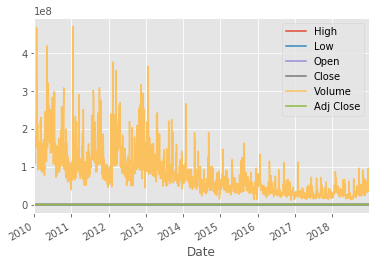

In [6]:
df.plot()
plt.show()

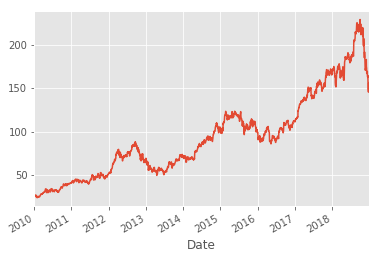

In [7]:
df['Adj Close'].plot()
plt.show()

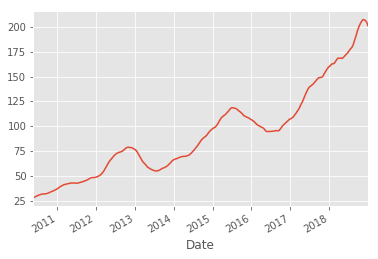

In [8]:
df['100ma'] = df['Adj Close'].rolling(window=100).mean()
df.dropna(inplace=True)
df['100ma'].plot()
plt.show()

In [3]:
import plotly_express as px

df_1 = df
df_1['dates'] = df.index

px.line(df_1,y='Adj Close',x='dates')

In [4]:
%matplotlib notebook 

ax1 = plt.subplot2grid((6,1),(0,0),rowspan=5,colspan=1)
ax2 = plt.subplot2grid((6,1),(5,0),rowspan=1,colspan=1,sharex=ax1)
ax1.plot(df.index,df['Adj Close'])
ax1.plot(df.index,df['100ma'])
ax2.bar(df.index,df['Volume'])
plt.show()

In [2]:
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates

In [8]:
df_ohlc = df['Adj Close'].resample('10D').ohlc()
df_ohlc.head()

,open,high,low,close
Date,,,,
2010-01-04,26.782711,26.829010,25.995537,26.362217
2010-01-14,26.209538,26.911612,24.747818,24.747818
2010-01-24,25.413599,26.015560,24.035734,24.511295
2010-02-03,24.933033,25.076958,24.034487,25.076958
2010-02-13,25.454903,25.454903,25.081959,25.081959


In [16]:
df_volume = df['Volume'].resample('10D').sum()
df_volume.head()

Date
2010-05-26    1.326496e+09
2010-06-05    1.166854e+09
2010-06-15    1.500679e+09
2010-06-25    1.181106e+09
2010-07-05    1.251777e+09
Freq: 10D, Name: Volume, dtype: float64

<IPython.core.display.Javascript object>


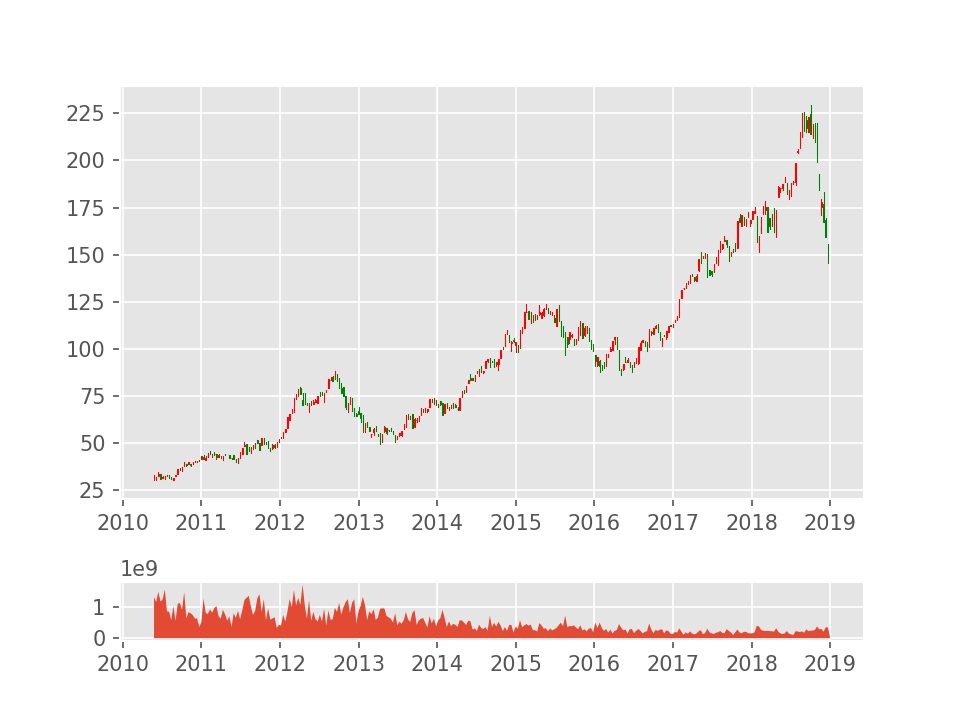

In [17]:
%matplotlib notebook

df_ohlc.reset_index(inplace=True)
df_ohlc['Date']=df_ohlc['Date'].map(mdates.date2num)

ax1 = plt.subplot2grid((8,1),(0,0),rowspan=6,colspan=1)
ax2 = plt.subplot2grid((8,1),(7,0),rowspan=2,colspan=1,sharex=ax1)
ax1.xaxis_date()

candlestick_ohlc(ax1,df_ohlc.values,width=2,colorup='r',colordown='g')
ax2.fill_between(df_volume.index.map(mdates.date2num),df_volume.values,0)
plt.show()

## Automatting getting S&P500 list

In [3]:
import bs4 as bs
import pickle
import requests

In [4]:
def save_SP500_tickers():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text,'lxml')
    table = soup.find('table',{'class':"wikitable sortable"})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        ticker = ticker[:-1]   #避免输出\n
        tickers.append(ticker)
        
    with open('sp500tickers.pickle','wb') as f:
        pickle.dump(tickers,f)
        
#     print(f)
    
    return tickers
    

In [5]:
save_SP500_tickers()

In [5]:
import datetime as dt
import os
import pandas_datareader.data as web

In [6]:
def get_data_from_yahoo(reload_sp500 = False):
    if reload_sp500:
        tickers = save_SP500_tickers()
    else:
        with open('sp500tickers.pickle','rb') as f:
            tickers = pickle.load(f)
    
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')
        
    start = dt.datetime(2000,1,1)
    end = dt.datetime(2018,12,31)
    
    for ticker in tickers[:72]:   #It may take 30 minutes to download all 500 companies data
        print(ticker)   #Check if it is working. Can be comment out
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)): #format()函数将ticker填充到{}中
            df = web.DataReader(ticker, 'yahoo', start, end)
            df.to_csv('stock_dfs/{}.csv'.format(ticker))
        else:
            print('Already have {}'.format(ticker))

In [6]:
get_data_from_yahoo()

## Combining into one DataFrame

In [11]:
def compile_data():
    with open('sp500tickers.pickle','rb') as f:
        tickers = pickle.load(f)[:72]
        
    main_df = pd.DataFrame()
    
    for count,ticker in enumerate(tickers):
        df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
        df.set_index('Date',inplace =True)
        
        df.rename(columns = {'Adj Close':ticker},inplace=True)
        df.drop(['Open','High','Low','Close','Volume'],1,inplace = True)
        #这里如若少drop一列（例如‘Close’），join时默认保留所有df中的该列。保留则需要设定suffixes=['_l', '_r'，...],共计30个后缀，否则会报错。
        
        if main_df.empty:
            main_df = df
        else:
            main_df = main_df.join(df,how='outer')

        if count%5 == 0:
            print(count)       # Checking if it's runing well

    print(main_df.head())
    main_df.to_csv('stock_dfs/sp500_joined_closes.csv')

In [12]:
compile_data()

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  29.367687  9.753512   NaN  18.25000  NaN  1.235628  16.274673   
2000-01-04  28.200748  9.474838   NaN  17.81250  NaN  1.198042  14.909401   
2000-01-05  29.017607  9.457423   NaN  18.00000  NaN  1.202740  15.204173   
2000-01-06  31.351456  9.788344   NaN  18.03125  NaN  1.179249  15.328290   
2000-01-07  31.973816  9.892846   NaN  17.93750  NaN  1.212137  16.072983   

               AMD  AAP        AES  ...      AZO        AVB        AVY  \
Date                                ...                                  
2000-01-03  15.500  NaN  29.248501  ...  30.5625  14.969457  42.602695   
2000-01-04  14.625  NaN  28.088650  ...  30.4375  14.638631  42.043133   
2000-01-05  15.000  NaN  28.391220  ...  30.3125  14.776474  43.423424   
2000-01-06  16.000  NaN  28.618151  ...  29.062

## S&P 500 Correlation table

In [9]:
import matplotlib.pyplot as plt
import matplotlib as style
import numpy as np
plt.style.use('ggplot')

In [10]:
def visualize_data():
    df = pd.read_csv('stock_dfs/sp500_joined_closes.csv')
#     df['AMZN'].plot()
    df_corr = df.corr()
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1) #1 by 1 and the first one
    data = df_corr.values #We only use the values and omit index and columns. It is now a np.array
    heatmap = ax.pcolor(data,cmap=plt.cm.RdYlGn)
    fig.colorbar(heatmap)
    ax.set_xticks(np.arange(data.shape[0]) + 0.5, minor = False)
    ax.set_yticks(np.arange(data.shape[1]) + 0.5, minor = False)
    
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    
    column_label = df_corr.columns
    row_label = df_corr.index
    
    ax.set_xticklabels(column_label)
    ax.set_yticklabels(row_label)
    plt.xticks(rotation = 90)
    heatmap.set_clim(-1,1)  # color limit: -1 is minimum and 1 is maximum
    plt.tight_layout()
    
    plt.show()

<IPython.core.display.Javascript object>


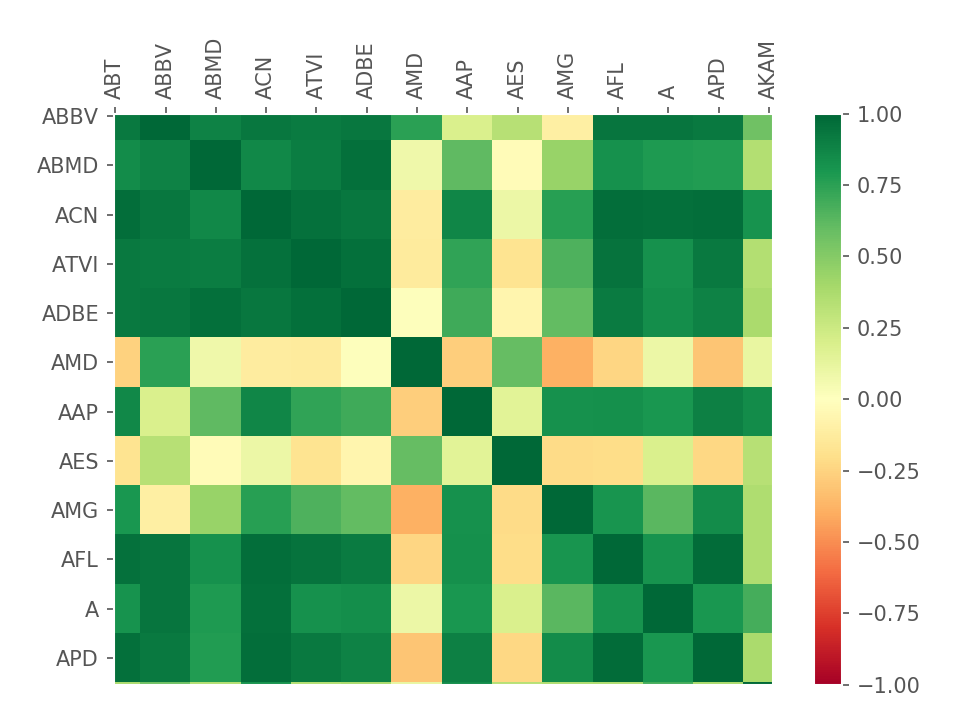

In [11]:
%matplotlib notebook
visualize_data()

## Preprocessing data for Machine Learning

In [41]:
def process_data_for_labels(ticker):
    hm_days = 7
    df = pd.read_csv('stock_dfs/sp500_joined_closes.csv',index_col = 0) #将第一列设为了index
    tickers = df.columns.values.tolist()
    df.fillna(0,inplace = True)
    
    for i in range(1, hm_days+1):
        df['{}_{}d'.format(ticker, i)] = (df[ticker].shift(-i) - df[ticker]) / df[ticker]  #shift负数表示向上移动
        
    df.fillna(0, inplace = True)
    
    return tickers,df
    

In [44]:
process_data_for_labels(ticker = 'AAPL')

(['MMM',
  'ABT',
  'ABBV',
  'ABMD',
  'ACN',
  'ATVI',
  'ADBE',
  'AMD',
  'AAP',
  'AES',
  'AMG',
  'AFL',
  'A',
  'APD',
  'AKAM',
  'ALK',
  'ALB',
  'ARE',
  'ALXN',
  'ALGN',
  'ALLE',
  'AGN',
  'ADS',
  'LNT',
  'ALL',
  'GOOGL',
  'GOOG',
  'MO',
  'AMZN',
  'AMCR',
  'AEE',
  'AAL',
  'AEP',
  'AXP',
  'AIG',
  'AMT',
  'AWK',
  'AMP',
  'ABC',
  'AME',
  'AMGN',
  'APH',
  'APC',
  'ADI',
  'ANSS',
  'ANTM',
  'AON',
  'AOS',
  'APA',
  'AIV',
  'AAPL',
  'AMAT',
  'APTV',
  'ADM',
  'ARNC',
  'ANET',
  'AJG',
  'AIZ',
  'ATO',
  'T',
  'ADSK',
  'ADP',
  'AZO',
  'AVB',
  'AVY',
  'BHGE',
  'BLL',
  'BAC',
  'BK',
  'BAX',
  'BBT',
  'BDX'],
                    MMM        ABT       ABBV        ABMD         ACN  \
 Date                                                                   
 2000-01-03   29.367687   9.753512   0.000000   18.250000    0.000000   
 2000-01-04   28.200748   9.474838   0.000000   17.812500    0.000000   
 2000-01-05   29.017607   9.457423   0.000

## Create machine learning target function

In [ ]:
def buy_sell_hold(*args):  #*args will handle for any number of parameters, and **kwargs will handle for any number of keyword arguments (hence kwargs)
    cols = [c for c in args]
    requirement = 0.02
    for col in cols:
        if col >requirement:
            return 1
        if col<-requirement:
            return -1
    return 0    

In [7]:
# About generator and list comprehension
xyz = (i for i in range(10)) #This is a generator, which generates values on-the-fly and saves memory
print(list(xyz)[0:5])

xyz = [i for i in range(10)] #This is a list comprehension, which creates list, uses more memory but reads faster
print(xyz[0:5])

[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]


In [1]:
def blog_posts_3(**kwargs):
    for title, post in kwargs.items():
        print(title,post)

blog_posts_3(blog_1 = 'I am so awesome',
             blog_2 = 'Cars are cool.',
             blog_3 = 'Aww look at my cat.')

blog_1 I am so awesome
blog_2 Cars are cool.
blog_3 Aww look at my cat.


In [ ]:
from collections import Counter
def extract_featuresets(ticker):
    tickers,df = process_data_for_labels(ticker)
    df['{}_target'.format(ticker)] = list(map( buy_sell_hold,
                                               df['{}_1d'.format(ticker)],
                                               df['{}_2d'.format(ticker)],
                                               df['{}_3d'.format(ticker)],
                                               df['{}_4d'.format(ticker)],
                                               df['{}_5d'.format(ticker)],
                                               df['{}_6d'.format(ticker)],
                                               df['{}_7d'.format(ticker)] ))